In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project : 멋진 작사가 만들기

### 라이브러리 버전 확인

In [ ]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import numpy as np

print(tf.__version__)

2.8.2


### Step 1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

### Step 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이함.  
glob을 활용하여 모든 txt 파일을 읽어온 후, raw_corpus리스트 문장 단위로 저장하도록 함.  

In [ ]:
import glob
import os

# txt_file_path = os.getenv('HOME')+'/content/drive/MyDrive/01.개인폴더/01. study/02. AIFFEL/03.Explore/[Exp_06]project_NLP_lyricistmaker/data/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
txt_file_path = "/content/drive/MyDrive/data/*"
txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


### Step 3. 데이터 정제

- preprocess_sentence() 활용
- 지나치게 긴문장은 과도한 padding을 갖게하고, 노래 가사 작사에도 어울리지 않음
- 그러므로 토큰 수가 15개를 넘어가는 문장을 학습 데이터에서 제외

In [ ]:
import re
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r'[.]+', "." , sentence) # 2 마침표가 여러개인것을 하나로
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 3
    sentence = re.sub(r'[" "]+', " ", sentence) # 4
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) # 5
    sentence = sentence.strip() # 6
    sentence = '<start> ' + sentence + ' <end>' # 7
    return sentence
# print(preprocess_sentence("sdjf  dsf ..................."))

In [ ]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue # 길이가 15초과인 문장 제외
    corpus.append(preprocessed_sentence)
    
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 "<start> i don't even wanna waste your time <end>",
 "<start> let's just say that maybe <end>",
 '<start> you could help me ease my mind <end>',
 "<start> i ain't mr . right but if you're looking for fast love <end>",
 "<start> if that's love in your eyes <end>",
 "<start> it's more than enough <end>",
 '<start> had some bad love <end>']

In [ ]:
for i in corpus:
    if len(i.split()) > 15:
        print(i)

In [ ]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 294  26 ...   0   0   0]
 [  2 223  12 ...   0   0   0]
 [  2  22  15 ...   0   0   0]
 ...
 [  2  24  71 ...   0   0   0]
 [  2  37  21 ...   0   0   0]
 [  2  24  71 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fb6d249f290>


In [ ]:
tensor.shape

(158745, 15)

In [ ]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


### Step 4. 평가 데이터셋 분리

훈련데이터와 평가 데이터를 분리하세요

- tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_spit() 함수를 사용해 훈련 데이털와 평가 데이터를 분리
- 단어장의 크기는 12,000 이상으로 설정하세요.
- 총 데이터의 20%를 평가 데이터셋으로 사용해주세요.

In [ ]:
src_input = tensor[:,:-1]
tgt_input = tensor[:,1:]
print(src_input[0])
print(tgt_input[0])

[   2  294   26   91 4638    3    0    0    0    0    0    0    0    0]
[ 294   26   91 4638    3    0    0    0    0    0    0    0    0    0]


In [ ]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          random_state = 42,
                                                          test_size = 0.2)

### Step 5. 인공지능 만들기

In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = len(tokenizer.index_word) + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

__LSTM 모델 사용__

In [ ]:
# 
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
#         self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  # 모델층을 하나 더 쌓아보자
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(len(tokenizer.index_word) + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [ ]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset_train.take(1): 
#     print(src_sample, tgt_sample)
    break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 27536), dtype=float32, numpy=
array([[[-2.25353542e-05,  1.80994335e-04,  8.87418937e-05, ...,
          9.92607384e-05, -1.67836581e-04, -2.55011197e-04],
        [-4.76857531e-05,  3.67293047e-04,  2.24057876e-04, ...,
          1.60270502e-04, -1.80182687e-04, -4.18146083e-04],
        [-3.84911073e-05,  5.24488278e-04,  2.73107231e-04, ...,
          2.42258029e-04, -1.35404684e-04, -7.78851856e-04],
        ...,
        [ 1.96668785e-03,  1.10680994e-03, -1.01561437e-03, ...,
          2.29861098e-03,  1.51817792e-03, -2.65723756e-05],
        [ 2.35786452e-03,  1.21477433e-03, -1.14767184e-03, ...,
          2.58746487e-03,  1.97544927e-03,  1.81161682e-04],
        [ 2.69098813e-03,  1.30149967e-03, -1.25661283e-03, ...,
          2.81376159e-03,  2.34799692e-03,  3.52883304e-04]],

       [[-2.25353542e-05,  1.80994335e-04,  8.87418937e-05, ...,
          9.92607384e-05, -1.67836581e-04, -2.55011197e-04],
        [-2.89755524e-04,  2.67671712e-04,  1

In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  14098432  
                                                                 
 lstm (LSTM)                 multiple                  20979712  
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  56421264  
                                                                 
Total params: 125,062,032
Trainable params: 125,062,032
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history = model.fit(dataset_train, epochs=10, validation_data = dataset_val) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/10
210/487 [===========>..................] - ETA: 3:57:13 - loss: 3.7829

__LSTM 학습 결과 시각화__

In [ ]:
import matplotlib.pyplot as plt

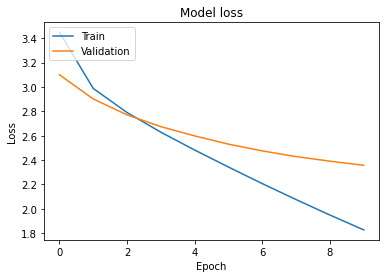

In [ ]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

__GRU 모델 사용__

In [ ]:
# 파라미터 
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = len(tokenizer.index_word) + 1  

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.GRU(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
#         self.rnn_3 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
#         self.rnn_4 = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

    
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(len(tokenizer.index_word) + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [ ]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset_train.take(1): 
#     print(src_sample, tgt_sample)
    break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 27536), dtype=float32, numpy=
array([[[ 7.48785096e-04, -8.19858396e-04, -4.57908085e-04, ...,
          9.37801815e-05, -1.13919936e-03, -8.60390777e-04],
        [ 2.49136100e-03, -4.33925277e-04,  1.36024362e-04, ...,
          1.33601238e-03,  5.28023927e-04, -7.87298311e-04],
        [ 1.79858669e-03,  5.38861059e-05,  2.76111619e-04, ...,
          9.37702658e-04,  9.66013118e-04,  3.25022847e-04],
        ...,
        [ 4.31915076e-04,  3.28789232e-03,  2.27747741e-03, ...,
          1.16935757e-03,  4.94826119e-03, -2.95590446e-03],
        [ 3.46528919e-04,  3.44574172e-03,  2.33696122e-03, ...,
          1.04629912e-03,  5.18256752e-03, -2.90284795e-03],
        [ 2.68768519e-04,  3.55206290e-03,  2.35326239e-03, ...,
          9.42386221e-04,  5.32901427e-03, -2.81405752e-03]],

       [[ 7.48785096e-04, -8.19858396e-04, -4.57908085e-04, ...,
          9.37801815e-05, -1.13919936e-03, -8.60390777e-04],
        [-5.57079678e-04,  1.13220257e-03, -4

In [ ]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  14098432  
                                                                 
 gru (GRU)                   multiple                  15740928  
                                                                 
 gru_1 (GRU)                 multiple                  25178112  
                                                                 
 dense_1 (Dense)             multiple                  56421264  
                                                                 
Total params: 111,438,736
Trainable params: 111,438,736
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history = model.fit(dataset_train, epochs=6, validation_data = dataset_val) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/6
496/496 [==============================] - 22s 39ms/step - loss: 3.2045 - val_loss: 2.8036
Epoch 2/6
496/496 [==============================] - 19s 38ms/step - loss: 2.5954 - val_loss: 2.5040
Epoch 3/6
496/496 [==============================] - 19s 38ms/step - loss: 2.1775 - val_loss: 2.3370
Epoch 4/6
496/496 [==============================] - 19s 38ms/step - loss: 1.8285 - val_loss: 2.2496
Epoch 5/6
496/496 [==============================] - 19s 38ms/step - loss: 1.5641 - val_loss: 2.2060
Epoch 6/6
496/496 [==============================] - 19s 38ms/step - loss: 1.3668 - val_loss: 2.1972


__GRU 학습 결과 시각화__

In [ ]:
import matplotlib.pyplot as plt

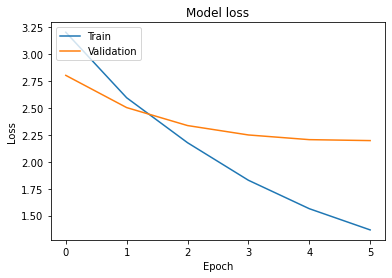

In [ ]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 모델 함수 만들기

In [ ]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [ ]:
# 원하는 시작 단어를 입력하면 자동으로 문장을 만들어주는 모델 
# 그냥 엔터를 치면 종료됨
while True:
    sentence = input("시작 단어 : ")
    gentext = generate_text(model, tokenizer, init_sentence = "<start> "+ sentence, max_len=100)
    print("출력단어",gentext[8:-7])
    
    if sentence == "":
        print("프로그램 종료")
        break

시작 단어 : 
출력단어 i don't know why
프로그램 종료


In [ ]:
# 꼬리를 무는 문장 만들기
sentence = input("시작 단어 : ")
for i in range(10):
    gentext = generate_text(model, tokenizer, init_sentence = "<start> "+ sentence, max_len=50)
    print(gentext[8:-7])
    if sentence != gentext[8:-7].split()[-1]:
        sentence = gentext[8:-7].split()[-1]
#     else:
#         sentence = gentext[8:-7].split()[-2]

시작 단어 : 
i don't know why
why you wanna get with me
me and my homies , so drop that
that you could even get a little state of control
control of me
me and my homies , so drop that
that you could even get a little state of control
control of me
me and my homies , so drop that
that you could even get a little state of control


### 루브릭
1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?
    - 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
    - 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?
1. 텍스트 생성모델이 안정적으로 학습되었는가?
    - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

## 회고
1. 모델 학습시간이 오래 걸려서 이런저런 튜닝을 못해본것이 아쉬운 점이 었다. 
1. 텍스트 데이터를 전처리 하기 위한 방법들을 공부하게 되어서 앞으로 크롤링이나 그런 부분에서 다양하게 사용할 수 있을것 같다. 
1. 좀 더 긴 문장을 만드는 방법을 생각해보다가 끝말잇기 처럼 처음에 문장을 집어 넣으면 완성된 문장을 나오고 완성된 문장에서 마지막 단어를 다시 입력받아서 다음 문장을 다시 출력하는 형태의 코드를 만들어 봤다. 그런데 \<unk> 많이 나오거나, 너무 짧은 문장이 완성되어서 다음문장이 출력이 되지 않는 문제가 있었다.
1. NLP는 소비자들의 다양한 것들을 분석할 수 있을것 같아서 좀 더 공부를 해보고 싶다. 
1. 이번 프로젝트에서 LSTM과 GRU 모델을 둘 다 사용해 봤는데 확실히 GRU 모델이 성능이 더 좋았다.
1. 또한 두 모델 모두 일정 epoch 이상 돌렸을 때, 오히려 loss가 높아지는 모습을 보였다. 
1. 또한 층을 많이 쌓는다고 무조건 좋은것도 아니었다. 오히려 과적합이 발생했다. 